In [19]:
!git clone https://github.com/Jsrsky/machine_unlearning_experiments
%cd machine_unlearning_experiments/experiments/mnist/influence
!pip install loguru

Cloning into 'machine_unlearning_experiments'...
remote: Enumerating objects: 465, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 465 (delta 14), reused 34 (delta 9), pack-reused 374 (from 3)
Receiving objects: 100% (465/465), 628.99 MiB | 44.06 MiB/s, done.
Resolving deltas: 100% (149/149), done.
Updating files: 100% (69/69), done.
/kaggle/working/machine_unlearning_experiments/experiments/mnist/influence/machine_unlearning_experiments/experiments/mnist/influence


## Dependecies

In [20]:
from pathlib import Path
import sys
import copy
from torchvision import datasets

In [21]:
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from tqdm import tqdm, trange
import numpy as np
from loguru import logger

## Utils 

In [22]:
project_root = Path.cwd().resolve().parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    
data_root = project_root / 'data'
data_root.mkdir(parents=True, exist_ok=True)

from notebook_setup import setup_notebook
setup_notebook()

Notebook setup completed. Project root added to sys.path: /kaggle/working/machine_unlearning_experiments


In [23]:
# Device configuration
from utils.utils import DEVICE

print(f"Device used: {DEVICE}")

# Set random seed for reproducibility
from utils.utils import set_seed
set_seed()

from utils.utils import save_model

from models.simple_cnn import load_model_cnn, init_model_cnn

# Merics 
from utils.train_test_metrics import test_model, show_metrics

# Recreate Dataloaders from json files
from methods.naive.naive_utils import recreate_dataloaders

# # Fisher Information Matrix (FIM) calc and unlearning with FIM
# from methods.influence.influence_utils import influence_unlearn, create_unlearning_dataloader

Device used: cuda


## Parameters (arbitrary chosen)

In [24]:
BATCH_SIZE = 2048
MINI_BATCH_SIZE = 2048

EPS = 1e-4
MAX_NORM = 1 #0.5
CG_ITERS = 10
SCALE = 10

# CALL FISHER

### Files

In [25]:
model_file = project_root / 'experiments/mnist/influence/influence_CNN_MNIST_model.pth'
samples_to_unlearn_file = project_root / 'experiments/mnist/naive/mnist_samples_to_unlearn_30per.json'
remaining_dataset_file = project_root / 'experiments/mnist/naive/updated_mnist_data_splits.json'

### Init models

In [26]:
original_model, original_model_name, criterion, _optimizer, transform = load_model_cnn(model_pth_path=model_file)

model_to_unlearn = copy.deepcopy(original_model)
model_to_unlearn_name = 'influence_' + original_model_name


import torch.nn as nn
model_to_unlearn = nn.DataParallel(model_to_unlearn, device_ids=[0, 1])

Load model...
Init model...
Done initializing model.
Model ID: 135067053790480, Optimizer ID: 135063749646160, Criterion ID: 135063749644144
Done loading model.


## Init data

In [27]:
train_dataset = datasets.MNIST(root=data_root, train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root=data_root, train=False, transform=transform, download=True)

In [28]:
from methods.fisher.fisher_utils import create_unlearning_dataloader

In [29]:
unlearn_indices, unlearn_loader = create_unlearning_dataloader(samples_to_unlearn_file, train_dataset, batch_size = MINI_BATCH_SIZE)

In [30]:
# train_loader, _val_loader, test_loader, classes = recreate_dataloaders(
#     data_splits_file=remaining_dataset_file,
#     datasets=(train_dataset, test_dataset), 
#     batch_size=BATCH_SIZE)

# unlearn_loader = create_unlearning_dataloader(samples_to_unlearn_file, train_dataset, batch_size = MINI_BATCH_SIZE)

### TUTAJ COS

In [31]:
from torch.amp import GradScaler, autocast
scaler = GradScaler()

def compute_gradient_on_subset(model, criterion, dataset_subset, batch_size):
    """
    Compute the average gradient Δ = (1/|D_u|) Σ_{(x,y) in D_u} ∇_θ L(θ, (x,y))
    over the dataset_subset.
    """
    dataloader = DataLoader(dataset_subset, batch_size=batch_size, shuffle=False)
    
    grad_dict = {name: torch.zeros_like(param, device=DEVICE)
                 for name, param in model.named_parameters() if param.requires_grad}
    
    total_samples = 0

    model.train()  # ensure gradients are computed
    for inputs, targets in tqdm(dataloader, desc="Computing gradients"):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        model.zero_grad()

        with autocast(device_type=str(DEVICE)):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
        scaler.scale(loss).backward()
        
        current_batch = inputs.size(0)
        total_samples += current_batch

        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is not None:
                grad_dict[name] += param.grad.detach().clone() * current_batch
        
        # for name, param in model.named_parameters():
        #     if param.requires_grad and param.grad is not None:
        #         if name not in grad_dict:
        #             grad_dict[name] = param.grad.detach().clone() * current_batch
        #         else:
        #             grad_dict[name] += param.grad.detach().clone() * current_batch

    # Average over total samples
    for name in grad_dict:
        grad_dict[name] /= total_samples

    # Flatten all gradients into one vector
    grad_vector = torch.cat([grad_dict[name].view(-1) for name in sorted(grad_dict.keys())])
    return grad_vector

def lissa_inverse_hvp(model, criterion, data_loader, v, damping=EPS, scale=SCALE, recursion_depth=20):
    ihvp_estimate = v.clone().to(DEVICE)
    data_iter = iter(data_loader)
    model.train()

    for _ in trange(recursion_depth, desc="LiSSA iterations", leave=False):
        try:
            inputs, targets = next(data_iter)
        except StopIteration:
            data_iter = iter(data_loader)
            inputs, targets = next(data_iter)

        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        model.zero_grad()

        with autocast(device_type=str(DEVICE)):
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        grad_vector = torch.nn.utils.parameters_to_vector(grads)

        hv = torch.autograd.grad(torch.dot(grad_vector, ihvp_estimate), model.parameters(), retain_graph=False)
        hv_vector = torch.cat([h.reshape(-1) for h in hv])

        # LiSSA recursive update
        ihvp_estimate = v + (1 - damping) * ihvp_estimate - hv_vector / scale

    return ihvp_estimate / scale


def lissa_inverse_hvp(model, criterion, data_loader, v, damping=EPS, scale=SCALE, recursion_depth=20):
    ihvp_estimate = v.clone().to(DEVICE)
    data_iter = iter(data_loader)
    model.train()

    for step in trange(recursion_depth, desc="LiSSA iterations", leave=False):
        try:
            inputs, targets = next(data_iter)
        except StopIteration:
            data_iter = iter(data_loader)
            inputs, targets = next(data_iter)

        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        model.zero_grad()

        # with autocast(device_type=str(DEVICE)):
        #     outputs = model(inputs)
        #     loss = criterion(outputs, targets)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        grad_vector = torch.nn.utils.parameters_to_vector(grads)

        if torch.isnan(grad_vector).any() or torch.isinf(grad_vector).any():
            print(f"🚨 [Debug] Step {step}: grad_vector has NaN/Inf!")
            return torch.zeros_like(v)

        hv = torch.autograd.grad(torch.dot(grad_vector, ihvp_estimate), model.parameters(), retain_graph=False)
        hv_vector = torch.cat([h.reshape(-1) for h in hv])

        if torch.isnan(hv_vector).any() or torch.isinf(hv_vector).any():
            print(f"🚨 [Debug] Step {step}: Hessian-vector product (hv_vector) has NaN/Inf!")
            return torch.zeros_like(v)

        ihvp_estimate = v + (1 - damping) * ihvp_estimate - hv_vector / scale

        if torch.isnan(ihvp_estimate).any() or torch.isinf(ihvp_estimate).any():
            print(f"🚨 [Debug] Step {step}: LiSSA update (ihvp_estimate) has NaN/Inf!")
            return torch.zeros_like(v)

    print("✅ [Debug] LiSSA estimation stable.")
    return ihvp_estimate / scale

# -----------------------------
# Helper Function: Hessian-Vector Product (HVP)
# -----------------------------
def hessian_vector_product(model, criterion, data_loader, v, damping=0.0):
    """
    Compute Hessian-vector product: Hv, averaged over the data in data_loader.
    This version is more vectorized by converting the gradients into a single flattened vector.
    """
    model.zero_grad()
    hvp_total = 0.0
    total_batches = 0

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        # Compute gradients as a vector
        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        grad_vector = torch.nn.utils.parameters_to_vector(grads)
        # Dot product with v
        grad_dot_v = torch.dot(grad_vector, v)
        # Compute second derivative: gradient of grad_dot_v w.r.t parameters
        hv = torch.autograd.grad(grad_dot_v, model.parameters(), retain_graph=False)
        # Use reshape instead of view to avoid contiguity issues
        hv_vector = torch.cat([h.reshape(-1) for h in hv])
        hvp_total += hv_vector
        total_batches += 1

    hvp_total /= total_batches
    return hvp_total + damping * v

# -----------------------------
# Helper Function: Conjugate Gradient (CG) Solver
# -----------------------------
def conjugate_gradient_solver(model, criterion, data_loader, b, cg_iters=50, residual_tol=1e-3, damping=0.0):
    """
    Solve Hx = b using Conjugate Gradient, where H is the Hessian computed on data_loader.
    Returns x ≈ H⁻¹ b.
    """
    x = torch.zeros_like(b, device=DEVICE)
    r = b.clone().to(DEVICE)
    p = r.clone().to(DEVICE)
    rdotr = torch.dot(r, r)
    
    for i in trange(cg_iters, desc="CG iterations", leave=False):
        Hp = hessian_vector_product(model, criterion, data_loader, p, damping)
        alpha = rdotr / (torch.dot(p, Hp) + 1e-8)
        x = x + alpha * p
        r = r - alpha * Hp
        new_rdotr = torch.dot(r, r)
        if new_rdotr < residual_tol:
            break
        beta = new_rdotr / (rdotr + 1e-8)
        p = r + beta * p
        rdotr = new_rdotr
    return x

# -----------------------------
# Main Function: Iterative Influence Unlearning
# -----------------------------
def iterative_influence_unlearn(model, criterion, full_dataset, removal_indices,
                                deletion_batch_size, compute_batch_size, eps, max_norm, cg_iters=50):
    """
    Implements iterative Influence Unlearning:
      For each mini-batch of deletion samples, compute the average gradient
      Δ_u, solve v ≈ H⁻¹ Δ_u using Conjugate Gradient on the remaining data,
      and update the model as: θ ← θ + v.
    
    Mathematical Equations:
      Δ_u = (1/|D_u^i|) Σ_{(x,y) in D_u^i} ∇_θ L(θ, (x,y))
      v ≈ H⁻¹ Δ_u,  where H = ∇²_θ L(θ, D \ D_u^i)
      θ ← θ + v
    """
    full_size = len(full_dataset)
    current_indices = set(range(full_size))

    # Partition removal_indices into mini-batches
    removal_list = list(removal_indices)
    num_batches = math.ceil(len(removal_list) / deletion_batch_size)
    partitioned_removals = [removal_list[i * deletion_batch_size : (i + 1) * deletion_batch_size]
                            for i in range(num_batches)]
    print(f"Total deletion samples: {len(removal_list)}; partitioned into {num_batches} mini-batches (each up to {deletion_batch_size} samples).")

    for i, batch in enumerate(tqdm(partitioned_removals, desc="Influence Unlearning")):
        # Update remaining indices: D_current ← D \ D_u^i
        current_indices -= set(batch)
        updated_indices = sorted(list(current_indices))
        dataset_remaining = Subset(full_dataset, updated_indices)
        print(f"Iteration {i+1}/{num_batches}: Remaining dataset size = {len(dataset_remaining)}")
        
        # Compute average gradient Δ_u for the deletion mini-batch
        deleted_subset = Subset(full_dataset, batch)
        delta = compute_gradient_on_subset(model, criterion, deleted_subset, compute_batch_size)

        if torch.isnan(delta).any() or torch.isinf(delta).any():
            print("🚨 [Debug] Gradient delta contains NaN/Inf!")
        else:
            print("✅ [Debug] Gradient delta stable.")
        
        # Create a DataLoader for remaining data to approximate Hessian
        remaining_loader = DataLoader(dataset_remaining, batch_size=compute_batch_size, shuffle=True)
        
        # # Solve for influence update: v ≈ H⁻¹ Δ_u using Conjugate Gradient
        # influence_update = conjugate_gradient_solver(model, criterion, remaining_loader, delta, cg_iters=cg_iters, damping=eps)

        influence_update = lissa_inverse_hvp(
            model, criterion, remaining_loader, delta, 
            damping=eps, scale=SCALE, recursion_depth=cg_iters
        )
        # Optionally clip the update to avoid overly large changes
        update_norm = influence_update.norm(2).item()
        if update_norm > max_norm or torch.isnan(update_norm) or torch.isinf(update_norm):
            print(f"WARNING: Clipping influence update from {update_norm:.2f} to {max_norm}")
            influence_update = influence_update * (max_norm / update_norm)
        print(f"Iteration {i+1}: Influence update norm = {influence_update.norm(2).item():.4f}")
        
        # Update model parameters: θ ← θ + v
        pointer = 0
        with torch.no_grad():
            for name, param in model.named_parameters():
                if param.requires_grad:
                    numel = param.numel()
                    update_segment = influence_update[pointer:pointer+numel].view_as(param)
                    param.data = param.data + update_segment
                    pointer += numel
        print(f"Iteration {i+1}/{num_batches} update completed.")
    
    return model

In [32]:
import time
start_time = time.perf_counter()


unlearned_model = iterative_influence_unlearn(model_to_unlearn, criterion, train_dataset, unlearn_indices,
                                                  MINI_BATCH_SIZE, BATCH_SIZE,
                                                  EPS, MAX_NORM, CG_ITERS)

end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

Total deletion samples: 18000; partitioned into 9 mini-batches (each up to 2048 samples).


Influence Unlearning:   0%|          | 0/9 [00:00<?, ?it/s]

Iteration 1/9: Remaining dataset size = 57952



Computing gradients: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


✅ [Debug] Gradient delta stable.



Influence Unlearning:  11%|█         | 1/9 [00:04<00:39,  4.98s/it]A

✅ [Debug] LiSSA estimation stable.
Iteration 1: Influence update norm = 1.0000
Iteration 1/9 update completed.
Iteration 2/9: Remaining dataset size = 55904



Computing gradients: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


✅ [Debug] Gradient delta stable.



Influence Unlearning:  22%|██▏       | 2/9 [00:09<00:34,  4.92s/it]A

✅ [Debug] LiSSA estimation stable.
Iteration 2: Influence update norm = 1.0000
Iteration 2/9 update completed.
Iteration 3/9: Remaining dataset size = 53856



Computing gradients: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


✅ [Debug] Gradient delta stable.



Influence Unlearning:  33%|███▎      | 3/9 [00:14<00:29,  4.98s/it]A

✅ [Debug] LiSSA estimation stable.
Iteration 3: Influence update norm = 1.0000
Iteration 3/9 update completed.
Iteration 4/9: Remaining dataset size = 51808



Computing gradients: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


✅ [Debug] Gradient delta stable.



Influence Unlearning:  44%|████▍     | 4/9 [00:19<00:24,  4.94s/it]A

✅ [Debug] LiSSA estimation stable.
Iteration 4: Influence update norm = 1.0000
Iteration 4/9 update completed.
Iteration 5/9: Remaining dataset size = 49760



Computing gradients: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


✅ [Debug] Gradient delta stable.



Influence Unlearning:  56%|█████▌    | 5/9 [00:24<00:20,  5.02s/it]A

✅ [Debug] LiSSA estimation stable.
Iteration 5: Influence update norm = 1.0000
Iteration 5/9 update completed.
Iteration 6/9: Remaining dataset size = 47712



Computing gradients: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


✅ [Debug] Gradient delta stable.



Influence Unlearning:  67%|██████▋   | 6/9 [00:29<00:14,  4.96s/it]A

✅ [Debug] LiSSA estimation stable.
Iteration 6: Influence update norm = 1.0000
Iteration 6/9 update completed.
Iteration 7/9: Remaining dataset size = 45664



Computing gradients: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


✅ [Debug] Gradient delta stable.



Influence Unlearning:  78%|███████▊  | 7/9 [00:34<00:10,  5.00s/it]A

✅ [Debug] LiSSA estimation stable.
Iteration 7: Influence update norm = 1.0000
Iteration 7/9 update completed.
Iteration 8/9: Remaining dataset size = 43616



Computing gradients: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


✅ [Debug] Gradient delta stable.



Influence Unlearning:  89%|████████▉ | 8/9 [00:39<00:05,  5.01s/it]A

✅ [Debug] LiSSA estimation stable.
Iteration 8: Influence update norm = 1.0000
Iteration 8/9 update completed.
Iteration 9/9: Remaining dataset size = 42000



Computing gradients: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


✅ [Debug] Gradient delta stable.



Influence Unlearning: 100%|██████████| 9/9 [00:45<00:00,  5.01s/it]A

✅ [Debug] LiSSA estimation stable.
Iteration 9: Influence update norm = 1.0000
Iteration 9/9 update completed.
Execution time: 45.085541 seconds


In [33]:
save_model(unlearned_model, f'{model_to_unlearn_name}_model1.pth')

### Test and metrics

In [34]:
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
classes = test_dataset.classes

In [35]:
model, *_ = init_model_cnn()


import torch.nn as nn
model = nn.DataParallel(model, device_ids=[0, 1])


model_path = f"{model_to_unlearn_name}_model1.pth"
test_model(model, model_to_unlearn_name, model_path, test_loader)
# test_model(model, model_to_unlearn_name, model_path, unlearn_loader)

Init model...
Done initializing model.
Model ID: 135063749887456, Optimizer ID: 135063749892448, Criterion ID: 135063749892832
Loading and testing model: influence_CNN_MNIST


Evaluating model: influence_CNN_MNIST_model1.pth: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

Predictions and labels saved to influence_CNN_MNIST_predictions.json


Metrics for influence_CNN_MNIST:
  - Test Accuracy: 0.9410
  - Precision: 0.9446
  - Recall: 0.9410
  - F1 Score: 0.9408


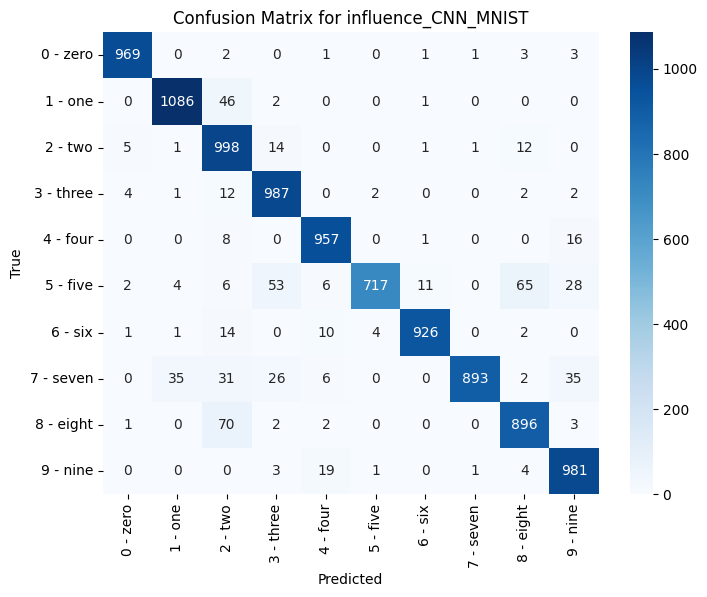

In [36]:
predictions_path = f'{model_to_unlearn_name}_predictions.json'
# classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
show_metrics(predictions_path, classes, model_to_unlearn_name)